In [14]:
import requests
import time
import pandas as pd
import numpy as np
from multiprocessing import Pool
import seaborn
from matplotlib import pyplot as plt

# MTG: Best booster box to buy
In this notebook we are going to show a statistical test that calculates the expected revenue obtained from a given box of booster for different sets of *Magic the Gathering*. Here is the problem:
Suppose that we buy a box of booster to sell the cards separately, afterwards. However, we only have one shot, I mean, we can only buy one box of booster, and there are several sets of expansions that we can choose to buy the box. That means that we need to pick the one with highest ROI, we need to *choose wisely*:
![alt text](download.jpg "Choose wisely")

Therefore, we are going to calculate the expected value obtained from a box of boosters. Then we will compare all the sets of expansions, and pick the one with highest expected revenue per card.

Well, first of all we need to gather all the information about the cards. For that purpose, we are going to use [Scryfall API](https://scryfall.com/docs/api), which gives us a thorough description of every card in each set. In particular, we are going to focus on the card's name, the rarity, the set and, of course, the price. Finally, the only sets we are going to focus on are the last 6 sets of *Stardard* version, since they are the ones that can be best sold in the future (they will still be Standard next year as well).

In [2]:
sets = "m19 xln hou akh rix dom".split()
cards = list()

for s in sets:
    has_more = True
    next_page = 'https://api.scryfall.com/cards/search?q=set%3A'+s
    while has_more:
        try:
            res = requests.get(next_page)
            result = res.json()
        
            card_batch = [(card['name'], card['eur'] if 'eur' in card else None, card['rarity'], card['set']) for card in result['data']]
            cards.extend(card_batch)
            has_more = result['has_more']
            if has_more:
                next_page = result['next_page']
            
            time.sleep(1)
        except Exception as e:
            has_more = False

After gathering all the information, we can create a *pandas* DataFrame, so that it is easier to handle all the data.

In [3]:
cards_df = pd.DataFrame(cards, columns=['name', 'price', 'rarity', 'set'])
cards_df['rarity_norm'] = cards_df['rarity'].apply(lambda r: 'rare' if r=='mythic' else r)

cards_df.head()

,name,price,rarity,set,rarity_norm
0,Abnormal Endurance,0.05,common,m19,common
1,Act of Treason,0.03,common,m19,common
2,Aegis of the Heavens,0.06,uncommon,m19,uncommon
3,Aerial Engineer,0.05,uncommon,m19,uncommon
4,Aethershield Artificer,0.05,uncommon,m19,uncommon


Seems perfect so far. Now we are going to move to the part where we calculate the expected revenue obtained by selling each card separately. 

### Sampling
In this section, we are going to sample several booster boxes for each expansion set, and then we will aggregate them all. 

In the first place, we are going to sample a booster. There are 11 common cards, 3 uncommon and 1 rare / mythic card per booster (there is also a land card, which we will not consider for the analysis since the price is minute). Besides, there might be repeated cards within a single booster. Therefore, we need to take 11 common cards from the pool of common cards, with replacement, then we will take 3 uncommon cards from the pool of uncommon cards, and the same with the rare card. **Note:** We will consider every card has the same probability of being picked in a booster.

That process is repeated 36 times, to get a sample of a booster box. We will repeat the sampling procedure 1000 times per expansion (that is the number of samples we have specified), which can be considered enough to get a sense of the actual revenue we can get from a selling cards. 

In particular, for the code, a multiprocessing library is going to be used, to boost the sampling times. Also, for the sampling part, *Numpy* library is going to be used, and then the results are going to be stored in a DataFrame.

In [4]:
n_samples = 1000 # Total number of samples to be run
n_cards = {'common':11, 'uncommon':3, 'rare':1} # Total number of cards per rarity in each booster
n_boosters = 36 # Boosters per box

def sample_booster_price(set_df, rarity, n):
    rarity_df = set_df[set_df['rarity']==rarity]
    return rarity_df.iloc[np.random.randint(0, rarity_df.shape[0], size=n)]['price'].astype(float).sum()

def sample_set(set_):
    # First we obtain the dataframe for the analyzed set
    set_df = cards_df[cards_df['set']==set_]
    
    # Now we sample an entire box a given number of times
    quants = [pd.DataFrame([{rarity: sample_booster_price(set_df, rarity, size)
                              for rarity, size in n_cards.iteritems()}
                            for _ in range(n_boosters)]).sum().to_dict()
              for _ in range(n_samples)]
        
    return pd.DataFrame(quants)

# We are going to parallelize the processing
p = Pool(6)
prices_per_set = p.map(sample_set, sets)
p.close()

Once we are done with the sampling we can take a look at the results obtained. First of all let's see some numbers by using the *describe* method provided by *Pandas*, which returns the most important univariate descriptive stats for every set.

In [12]:
for quants in prices_per_set:
    quants['total'] = quants[['common', 'uncommon', 'rare']].sum(1)
    
stats = pd.concat([q.describe()['total'].apply(lambda v: round(v, 3)).drop('count') for q in prices_per_set], 1)
stats.columns = sets
stats

,m19,xln,hou,akh,rix,dom
mean,50.159,78.893,49.669,51.373,61.812,53.030
std,4.520,14.608,4.300,3.951,7.365,5.624
min,37.160,48.690,37.550,41.870,43.280,35.620
25%,47.040,68.430,46.675,48.612,56.460,49.275
50%,49.985,77.295,49.400,51.200,61.590,52.780
75%,53.105,88.078,52.662,53.930,66.463,56.802
max,67.470,139.850,63.090,66.220,85.190,74.320


Each column in the table represents a set, and each row represents the univariate stats used to compare each set. The *mean* tells us the *expected revenue* obtained from selling the cards separately, or, in other words, is the average revenue obtained from selling cards separately for a box of boosters. Focusing in this number, it is clear that the set that might give us the greatest revenue is *xln*. 

The other important number to look at is the median, which separates the sample in two sets with the exact number of data points. That means, that at least 50% of the samples for *dom* might generate \$52.78 or more. In that sense, again *xln* is the most convenient set, since the median is by far the largest among all sets. 

In addition, it is important to see what are the minimum and maximum revenues which might be obtained from each set. If we check out the prices for the boxes to be bought, the only box which would give us some profit is *xln*, since its maximum sampled revenue is greater than the price to buy such box ([approximately $80](https://www.amazon.com/Magic-Gathering-Ixalan-Booster-Display/dp/B073RZLF2M/ref=sr_1_1?ie=UTF8&qid=1533273599&sr=8-1&keywords=magic+the+gathering+ixalan+booster+box)).

We can visualize all these descriptive statistics using a *Box-Plot*, which points out the three most used quantiles and also the outliers.

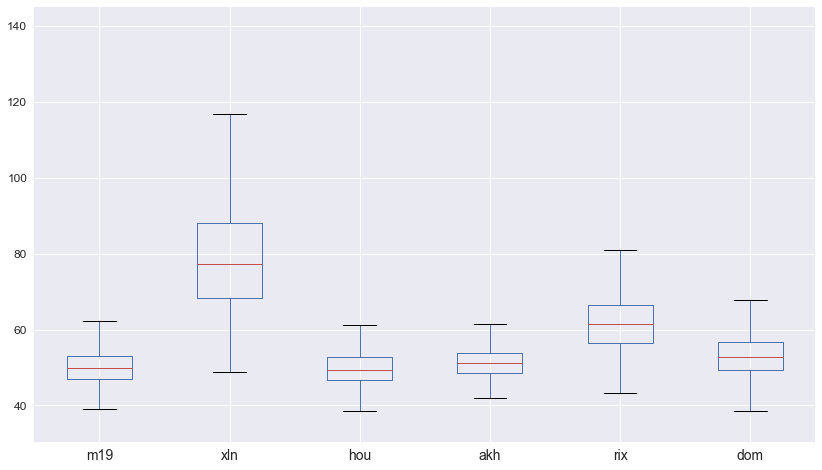

In [15]:
dfs = list()

for s, quants in zip(sets, prices_per_set):
    d = quants
    d[s] = d['total']
    dfs.append( d[s] )
    
plt.figure(figsize=(14, 8))
plt.xticks(fontsize=14)
plt.yticks(fontsize=12)
pd.concat(dfs, 1).boxplot()

plt.show()

In this chart the red line represents the median, the line delimiting the box from below is the Q1 or 25% quantile, the line delimiting the box from above is the Q3 or 75% quantile. The lines below and above the box are set to 1.5\*IQR, where IQR is the so-called *Inter-Quantil Range*, and shows how much the data extends to both sides of the half. Graphically, it is really easy to depict the difference between *xln* and the rest of the sets, with a median that is almost as large as the maximum values of *rix*.

Suppose now that we want to claim that there is sufficient evidence to say that *xln* has greater revenue than the rest of the expansions. Staticians don't like these kind of claims by simply doing a visual comparisons, they ask the statistics what is the set that returns the greatest revenue. Do not get me wrong, visual assesment is a crucial part of the procedure when comparing two groups. However, it is not enough, we need some statistics proofs. The way to get that is by implementing **statistical tests**.

### Distribution
Many statistical tests work assuming that the data follows a particular distribution, the most used is the *Normal Distribution*. Let's now see what are the distributions of the samples obtained for each set. First of all, we are going to use the *Histogram chart* which shows an approximation of the real distribution. 

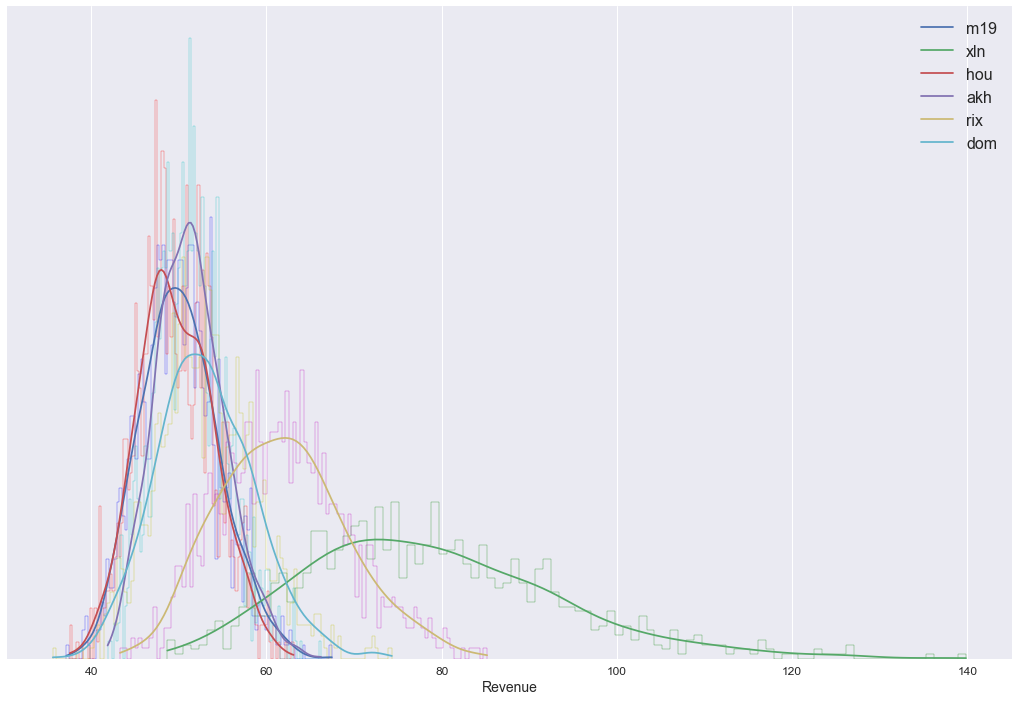

In [17]:
from matplotlib import pyplot as plt
import scipy.stats as stats

colors = "b g r c m y".split()

quants_per_set = dict(zip(sets, prices_per_set))

plt.figure(figsize=(18,12))
for s, color in zip(sets, colors):
    noise = pd.DataFrame(quants_per_set[s])['total'].values
    density = stats.gaussian_kde(noise)

    n, x, _ = plt.hist(noise, bins=100, color=color,
                       histtype=u'step', normed=True)  
    plt.plot(x, density(x))
    
plt.legend(sets, fontsize=16)
plt.xticks(fontsize=12)
plt.xlabel("Revenue", fontsize=14)
plt.yticks([])
plt.show()

Visually, they all seem Normal distributions, with the bell-shape form, even though there might be some skews on them. Again, it is possible to see that *xln* is a lot more profitable than the rest, since its mean is about \$78, and is larger than the maximum revenued obtained from the rest of the sets. Besides, we can see that the minimum revenue obtained from that set is close to the average revenue of the rest of the sets.



In [27]:
from scipy.stats import shapiro

t, p = shapiro(prices_per_set[2]['total'].values)
from statsmodels.graphics.gofplots import qqplot
qqplot(prices_per_set[0]['total'].values)

plt.show()

ImportError: No module named gofplots